In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopy.distance
from tqdm.auto import tqdm
import itertools
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(5,5)})

#### Set choices

USPS is among: 
```
print(sorted(census_tracts['USPS'].unique()))
['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
```
    

In [2]:
#filterUSPS = ['CA']
#filterUSPS = ['MD', 'DC', 'VA', 'DE', 'PA', 'NJ']
#filterUSPS = ['CA', 'OR', 'WA']
#foldername = 'around-maryland/'
#foldername = 'east-coast/'
foldername = './'

In [10]:
commute_data = pd.read_csv('united-states-commutes/commute_data.csv')
census_tracts = pd.read_csv('united-states-commutes/census_tracts_2010.csv')

#census_tracts = census_tracts[census_tracts['USPS'].isin(filterUSPS)]
commute_data = commute_data[commute_data['OFIPS'].isin(census_tracts['GEOID'].unique())]
commute_data = commute_data[commute_data['DFIPS'].isin(census_tracts['GEOID'].unique())]
census_tracts = census_tracts.sort_values('GEOID', ascending=True)
census_tracts.reset_index(inplace=True)
commute_data.reset_index(inplace=True)

From readme:

    - Ofips - the full FIPS code for the origin census tract of an individual flow line
    - Dfips  - the full FIPS code for the destination census tract of an individual flow line
    - Ostfips - the FIPS code for the origin state of an individual flow line
    - Octfips - the FIPS code for the origin county of an individual flow line
    - Otrfips - the FIPS code for the origin census tract of an individual flow line
    - Dstfips - the FIPS code for the destination state of an individual flow line
    - Dctfips - the FIPS code for the destination county of an individual flow line
    - Dtrfips - the FIPS code for the destination census tract of an individual flow line
    - Flow - the total number of commuters associated with this individual point to point flow line (i.e. the total number of journeys to work)
    - Moe - margin of error of the Flow value above
    - LenKM - length of each flow line, in Kilometers
    - ESTDIVMOE - the Flow value divided by the Margin of Error of the estimate 

In [11]:
commute_data.head()

,index,OFIPS,DFIPS,OSTFIPS,OCTFIPS,OTRFIPS,DSTFIPS,DCTFIPS,DTRFIPS,FLOW,MOE,LENKM,ESTDIVMOE
0,0,6073018700,6073018700,6,73,18700,6,73,18700,20950,2359,0.0,8.88
1,1,51710000902,51710000902,51,710,902,51,710,902,10155,2516,0.0,4.04
2,2,45079011501,45079011501,45,79,11501,45,79,11501,8735,875,0.0,9.98
3,3,13215010802,13215010802,13,215,10802,13,215,10802,7720,1144,0.0,6.75
4,4,6071010402,6071010402,6,71,10402,6,71,10402,7040,848,0.0,8.30


from https://www.census.gov/programs-surveys/geography/technical-documentation/records-layout/gaz10-record-layouts.html

    USPS	United States Postal Service State Abbreviation
    GEOID	Geographic Identifier - fully concatenated geographic code (State FIPS and district number)
    POP10	2010 Census population count.
    HU10	2010 Census housing unit count.
    ALAND	Land Area(square meters) - Created for statistical purposes only.
    AWATER	Water Area (square meters) - Created for statistical purposes only.
    ALAND_SQMI	Land Area (square miles) - Created for statistical purposes only.
    AWATER_SQMI	Water Area (square miles) - Created for statistical purposes only.
    INTPTLAT	Latitude (decimal degrees) First character is blank or "-" denoting North or South latitude respectively.
    INTPTLONG	Longitude (decimal degrees) First character is blank or "-" denoting East or West longitude respectively.

In [12]:
census_tracts.head()

,index,USPS,GEOID,POP10,HU10,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
0,0,AL,1001020100,1912,752,9809944,36312,3.788,0.014,32.477111,-86.490303
1,1,AL,1001020200,2170,822,3340505,5846,1.290,0.002,32.475758,-86.472468
2,2,AL,1001020300,3373,1326,5349274,9054,2.065,0.003,32.474024,-86.459703
3,3,AL,1001020400,4386,1823,6382705,16244,2.464,0.006,32.471078,-86.444681
4,4,AL,1001020500,10766,4308,11397725,48412,4.401,0.019,32.458916,-86.421817


(-150, -50)

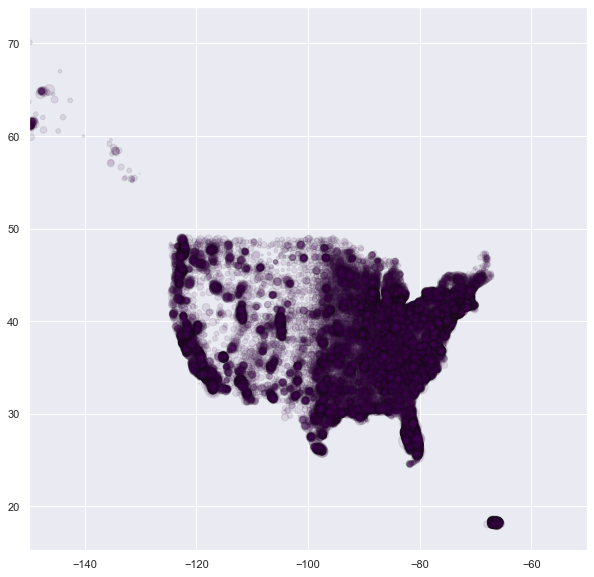

In [15]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.scatter(census_tracts['INTPTLONG'], census_tracts['INTPTLAT'], s =census_tracts['POP10']/100,
           edgecolors = 'k', c =census_tracts['POP10']/census_tracts['ALAND']*1e5, 
           cmap='viridis', alpha = .1)
ax.set_xlim(-150,-50)

In [16]:
# Augment commute data with our newly specified metrop:
ori_attr = np.empty(len(commute_data))
dest_attr = np.empty(len(commute_data))
ori_attr[:] = np.nan
dest_attr[:] = np.nan
for index, row in tqdm(commute_data.iterrows(), total=commute_data.shape[0]):
   
    ori_attr[index] =   census_tracts[census_tracts['GEOID'] == row['OFIPS']]['METROP']
    dest_attr[index] =  census_tracts[census_tracts['GEOID'] == row['DFIPS']]['METROP']

commute_data['OMETROP'] = ori_attr
commute_data['DMETROP'] = dest_attr

In [17]:
mobility = np.zeros((n_counties, n_counties))
for ori_i, ori_v in tqdm(enumerate(counties_names), total = len(counties_names)):
    for dest_i, dest_v in enumerate(counties_names):
        mobility[ori_i][dest_i] = commute_data[(commute_data['OMETROP'] == ori_v) & (commute_data['DMETROP'] == dest_v)]['FLOW'].sum()

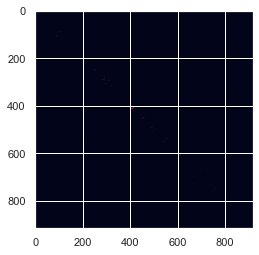

In [18]:
np.fill_diagonal(mobility,0)
mobility = mobility + mobility.T # Symetric mobility doubling fluxes mobility.sum is around 5M which is a bit low
plt.imshow(mobility)

In [78]:
np.savetxt(f'data/{foldername}mobility.txt', mobility)
california_data.to_csv(f'data/{foldername}geodata.csv', index_label='id')

In [19]:
np.savetxt(f'mobility_USA2010.txt', mobility)
california_data.to_csv(f'geodata_USA2010.csv', index_label='id')

In [21]:
mobility.shape

(916, 916)